## Import

In [3]:
#Import libraries
import numpy as np
import scipy.stats as sp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from discreteMarkovChain import markovChain

# Question 1 (HealthCare)

## Data

                $0  $0-$1000  $1000-$2000  $2000-$3000  $3000-$4000  \
$0           0.875     0.077        0.021        0.010        0.004   
$0-$1000     0.590     0.250        0.071        0.029        0.018   
$1000-$2000  0.392     0.183        0.249        0.075        0.029   
$2000-$3000  0.279     0.144        0.134        0.249        0.077   
$3000-$4000  0.216     0.103        0.064        0.145        0.198   
$4000-$5000  0.216     0.071        0.073        0.096        0.151   
$5000-$6000  0.190     0.101        0.057        0.062        0.094   
$6000-$7000  0.218     0.096        0.038        0.079        0.071   
$7000-$8000  0.188     0.102        0.076        0.061        0.076   
$8000+       0.229     0.104        0.068        0.068        0.060   

             $4000-$5000  $5000-$6000  $6000-$7000  $7000-$8000  $8000+  
$0                 0.003        0.002        0.001        0.001   0.005  
$0-$1000           0.009        0.005        0.006        0.003   0.01

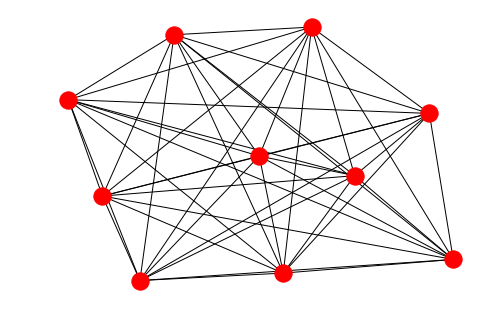

In [4]:
#Read health data, drop indices, drop extraneous rows & columns, format for math
health = pd.read_csv('health.csv')
health = health.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1)
health = health.drop([0,1])
health = health.values
health = health.astype('double')
#Recreate indices, return loaded data
costIndex = pd.Series(['$0',
                       '$0-$1000',
                       '$1000-$2000',
                       '$2000-$3000',
                       '$3000-$4000',
                       '$4000-$5000',
                       '$5000-$6000',
                       '$6000-$7000',
                       '$7000-$8000',
                       '$8000+'])
healthData = pd.DataFrame(health)
healthData.columns = costIndex
healthData.index = costIndex
print(healthData)
#Draw graph of health data transition network
nx.draw(nx.Graph(health))
plt.show()

In [5]:
healthSum = health.sum(axis=1)
healthSum

array([0.999, 0.999, 1.001, 1.001, 0.999, 1.   , 1.001, 0.999, 1.   ,
       1.001])

### ***ROWS DO NOT SUM TO 1, NOT A MARKOV STATE MATRIX***

## First Passage Probabilities

In [6]:
#Recursive method with helper function to calculate first passage probability
def firstPassage(P,i,j,N):
    P = np.asmatrix(P)        
    if N != 1: return (P**N)[i,j] - sigma(P,i,j,N)
    else: return (P[i,j])
def sigma(P,i,j,N):
    sig = 0
    for k in range(N-1,0,-1):
        sig = sig + (firstPassage(P,i,j,k))*(((P**(N-k))[j,j]))
    return sig    

## Answer 1

In [7]:
fin1 = np.zeros(shape=(5,6))
for N in range(1,7):
    for i in range(5,10):
        fin1[i-5][N-1] = firstPassage(health,i,0,N)
fin1 = pd.DataFrame(fin1)
fin1.columns = ['Month 1','Month 2','Month 3','Month 4','Month 5','Month 6']
fin1.index = ['$4000-$5000','$5000-$6000','$6000-$7000','$7000-$8000','$8000+']
fin1.to_csv('ans1.csv')
print(fin1)

             Month 1   Month 2   Month 3   Month 4   Month 5   Month 6
$4000-$5000    0.216  0.213792  0.175920  0.128192  0.088548  0.059730
$5000-$6000    0.190  0.222408  0.180274  0.131601  0.091514  0.062088
$6000-$7000    0.218  0.212110  0.173729  0.127234  0.088568  0.060111
$7000-$8000    0.188  0.229326  0.181090  0.130373  0.090009  0.060849
$8000+         0.229  0.223110  0.172383  0.122858  0.084409  0.056933


## Mean First Passage Time 
### (As described by Solberg & Timothy Klocker)

In [8]:
def mfpt(P,i,j):
    P = np.asmatrix(P)
    I = P.copy()
    I[:] = 0
    np.fill_diagonal(I,1)
    onevec = np.ones((len(P),1))
    P[:,j] = 0
    A = I - P
    A = np.linalg.inv(A)
    Avec = A.sum(axis=1)
    return Avec[i,0]

## Answer 2

In [9]:
fin2 = []
for i in range(5,10):
    fin2.append(mfpt(health,i,0))
fin2 = pd.Series(fin2)
fin2.index = ['$4000-$5000','$5000-$6000','$6000-$7000','$7000-$8000','$8000+']
fin2.to_csv('ans2.csv')
print(fin2)

$4000-$5000    3.541847
$5000-$6000    3.636461
$6000-$7000    3.547321
$7000-$8000    3.606930
$8000+         3.455446
dtype: float64


## Conclusions

### First Passage Probability
> Relatively unlikely in months 5 & 6

### Mean First Passage Time
> All mean first passage times are close to '3.5'

# Question 2 (PageRank)

## Data

In [10]:
#read web data, drop extraneous rows & columns, format for math
web = pd.read_csv('web.csv')
web = web.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1)
web = web.drop([0,1])
web = web.values
web = web.astype('double')
web = pd.DataFrame(web)

## Method

In [11]:
#Receives the matrix of links "sites", where links are denoted by '1' and absence by '0'
def pageRank(sites):
#Uses the input matrix to create a component "rand" to account for the 15% random path to any site
    rand = np.array(sites)
    #fills "rand" with '1's
    rand[:] = 1
    rand = rand - sites
#Sum all links in a row
    sitelinks = pd.Series(sites.sum(axis=1))
    randlinks = pd.Series(rand.sum(axis=1))
#Divide each row in the "sites" matrix by its sum
    sites = sites.T
    rand = rand.T
    for i in range(len(sites.index)):
        sites[i] = sites[i]/sitelinks[i]
        rand[i] = rand[i]/randlinks[i]
    sites = sites.T
    rand = rand.T
#Sum the working and random components with appropriate weights
#Return "final", the final PageRank transition matrix
    final = (0.85*sites) + (0.15*rand)
    return final

## Check Method

In [12]:
#Receives PageRank transition matrix
def rankCheck(final):
#Check that all rows sum to 1 by checking that all row sums sum to 100
    #i.e. "final" IS a markov state matrix
#Return the status of the check
    finalCheck = final.sum(axis=1)
    if (finalCheck.sum() == len(finalCheck)) and (len(final) == len(final.T)):
        return "PageRank!"
    else:
        return "This isn't working"

## Answer 3

In [13]:
#TEST
test = pageRank(web)
print(rankCheck(test))
print()
#Compute steady state vector, i.e. ranks of pages
mc = markovChain(test.values)
mc.computePi('linear')
final = (pd.Series(mc.pi))
final = final.sort_values(ascending=False)
final.to_csv('ans3.csv')
final

PageRank!



3     0.015116
93    0.015078
17    0.014977
65    0.014554
39    0.014088
28    0.013887
55    0.013878
22    0.013686
32    0.013623
27    0.013515
18    0.013502
8     0.013460
5     0.013451
57    0.013344
9     0.013253
43    0.013231
48    0.013175
97    0.013172
6     0.013148
49    0.013130
7     0.013122
14    0.013112
69    0.013015
36    0.013011
74    0.012989
77    0.012981
85    0.012921
62    0.012860
90    0.012729
41    0.012687
        ...   
31    0.008435
19    0.008213
42    0.007979
56    0.007780
86    0.007709
21    0.007383
13    0.007257
95    0.007179
53    0.007047
78    0.006657
10    0.006238
61    0.006185
67    0.006142
45    0.006124
46    0.005352
81    0.005026
2     0.004891
44    0.004756
76    0.004512
91    0.004325
0     0.004187
92    0.004142
16    0.003829
63    0.003666
82    0.003203
88    0.003045
12    0.002985
94    0.002976
33    0.002710
24    0.002601
Length: 100, dtype: float64